#Import and install modules

In [1]:
!pip install hazm

In [2]:
import re, hazm, os, json, nltk
import pickle
import statistics
import numpy as np
import pandas as pd
from nltk import word_tokenize 
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
nltk.download('wordnet')
nltk.download("stopwords")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#Load data

In [4]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("drive/My Drive")
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 AI-4.gdoc
 apply.gsheet
 classifier
'Colab Notebooks'
 CV.pdf
 data
'Email for Graduate Application.gdoc'
'My Prof.s.gsheet'
 nb_fa.sav
 nlp-project.ipynb
 points.json
 Prof.s.gsheet
'project Bsc'
'Recommendation Letter_Rezvan Karaji_Nevada.rtf'
 rf_fa.sav
 sop.gdoc
 SpamDetection.ipynb
 tfidf_fa.sav
 transcript-official.pdf
 tweet.csv


In [5]:
filename = 'tweet.csv'
data = pd.read_csv(filename, encoding='utf-8')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,5,6,11,12,13,43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#Analyze data

In [6]:
data.head()

,Unnamed: 0,id,username,title,about,members,posts_count,language,avg_view,last_dump_date,last_cold_date,duration_update,following_count,verified,favourites_count,location,url,join_date,deleted,index_name,UTC_date,date,views,retweet_count,text,fwdfrom,media,hashtags,to,from,post_id,link,dump_type,meta,is_adv,bi-keywords,keywords,neg_adj,pos_adj,sentiment,mentions,locations,urls,cashtags
0,0,9.772081e+17,jasooyichii,milad mohammadi,Exhibitions reporter/\nmr event/\norganizer of...,856,470,NaN,0.0,2020-10-26,2020-10-09,24,774,0,1927.0,tehran - iran,https://t.co/uz1hdKY1V8,2018-03-23T15:38:55,0.0,tw-sourceinfo-2020-10,2020-10-25T20:40:58,2020-10-25 17:10:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.314951e+18,NaN,NaN,NaN,NaN,NaN,fa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tw-user-2020-10,2020-10-10T15:29:51,2020-10-10 15:29:51,7897.0,457.0,آن شب اسفندماه که برای نخستین بار خبر درگذشت #...,"{'username': 'febrahimzade', 'id': '198563041'...",{'caption': 'آن شب اسفندماه که برای نخستین بار...,"['محمدرضاشجریان', 'افسانه_شجریان']","{'participants_count': 181, 'username': 'lonel...","{'participants_count': 181, 'username': 'lonel...",1886.0,https://twitter.com/i/web/status/1314951285540...,scheduled,['اجتماعی'],1.0,"['اسفندماه خبر', 'خبر درگذشت', 'درگذشت محمدرضا...","['پدر', 'درگذشت', 'علاقه', 'بیمارستان', 'پاسخ'...","['بار', 'درگذشت']","['آرامش', 'باور', 'زنده']",positive,NaN,NaN,NaN,NaN
2,2,1.314951e+18,NaN,NaN,NaN,NaN,NaN,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tw-user-2020-10,2020-10-10T15:28:26,2020-10-10 15:28:26,1.0,0.0,@daydreaminblack Niiiice😂😂😂😂😂,NaN,NaN,NaN,"{'participants_count': 181, 'username': 'lonel...","{'participants_count': 181, 'username': 'lonel...",1885.0,https://twitter.com/i/web/status/1314950928517...,scheduled,['متفرقه'],0.0,[],"['daydreaminblack', 'Niiiice']",NaN,NaN,neutral,['daydreaminblack'],NaN,NaN,NaN
3,3,1.314951e+18,NaN,NaN,NaN,NaN,NaN,fa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tw-user-2020-10,2020-10-10T15:28:00,2020-10-10 15:28:00,33.0,1.0,جدا از رفتن شجریان، چهر‌ه‌های غمبار همایون و ع...,"{'username': 'helia_hh', 'id': '3025201221', '...",NaN,NaN,"{'participants_count': 181, 'username': 'lonel...","{'participants_count': 181, 'username': 'lonel...",1884.0,https://twitter.com/i/web/status/1314950817338...,scheduled,['هنری'],0.0,"['رفتن شجریان', 'شجریان چهر', 'چهر غمبار', 'غم...","['رفتن', 'شجریان', 'مچاله', 'علیزاده', 'چهر', ...","['جدا', 'مچاله']",NaN,negative,NaN,NaN,NaN,NaN
4,4,1.314895e+18,NaN,NaN,NaN,NaN,NaN,fa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tw-user-2020-10,2020-10-10T11:47:36,2020-10-10 11:47:36,3046.0,191.0,دیگه تویی که تا دیروز عکس سردار دلها رو استوری...,"{'username': 'Javadhastam2', 'id': '1111065915...",{'caption': 'دیگه تویی که تا دیروز عکس سردار د...,NaN,"{'participants_count': 181, 'username': 'lonel...","{'participants_count': 181, 'username': 'lonel...",1883.0,https://twitter.com/i/web/status/1314895352772...,scheduled,['هنری'],1.0,"['تویی عکس', 'عکس سردار', 'سردار دلها', 'دلها ...","['عکس', 'استوری', 'تویی', 'شجریان', 'سردار', '...",['پست'],NaN,negative,NaN,NaN,NaN,NaN


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1196368 entries, 0 to 1196367
Data columns (total 44 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Unnamed: 0        1196368 non-null  object 
 1   id                1196355 non-null  float64
 2   username          257913 non-null   object 
 3   title             257719 non-null   object 
 4   about             176930 non-null   object 
 5   members           242382 non-null   object 
 6   posts_count       242381 non-null   object 
 7   language          938461 non-null   object 
 8   avg_view          242381 non-null   float64
 9   last_dump_date    242381 non-null   object 
 10  last_cold_date    242381 non-null   object 
 11  duration_update   242373 non-null   object 
 12  following_count   242369 non-null   object 
 13  verified          242381 non-null   object 
 14  favourites_count  242381 non-null   float64
 15  location          134416 non-null   object 
 16  

In [8]:
# topic
data = data[['language','text', 'meta']]

data.columns = ['lang', 'text', 'target']
data = data[1:]

In [9]:
data.head()

,lang,text,target
1,fa,آن شب اسفندماه که برای نخستین بار خبر درگذشت #...,['اجتماعی']
2,en,@daydreaminblack Niiiice😂😂😂😂😂,['متفرقه']
3,fa,جدا از رفتن شجریان، چهر‌ه‌های غمبار همایون و ع...,['هنری']
4,fa,دیگه تویی که تا دیروز عکس سردار دلها رو استوری...,['هنری']
5,fa,لازم نیست راجع‌به هر مسئله‌ای نظر بدی و موضع‌گ...,['مذهبی']


drop useless data

In [10]:
data = data[~data['target'].isnull()]
data = data[data['target'].notna()]
data = data[~data['text'].isnull()]
data = data[data['text'].notna()]

In [11]:
tages = list(set(data['target'].values))
tages

["['اجتماعی']",
 "['هنری']",
 "['ورزشی']",
 "['علمی_فرهنگی']",
 "['مذهبی']",
 "['سیاسی']",
 "['اقتصادی']",
 "['اقوام']",
 "['اخبارجهان']",
 "['فراخوان و تجمعات']",
 "['زنان']",
 "['فناوری']",
 "['متفرقه']"]

No handles with labels found to put in legend.


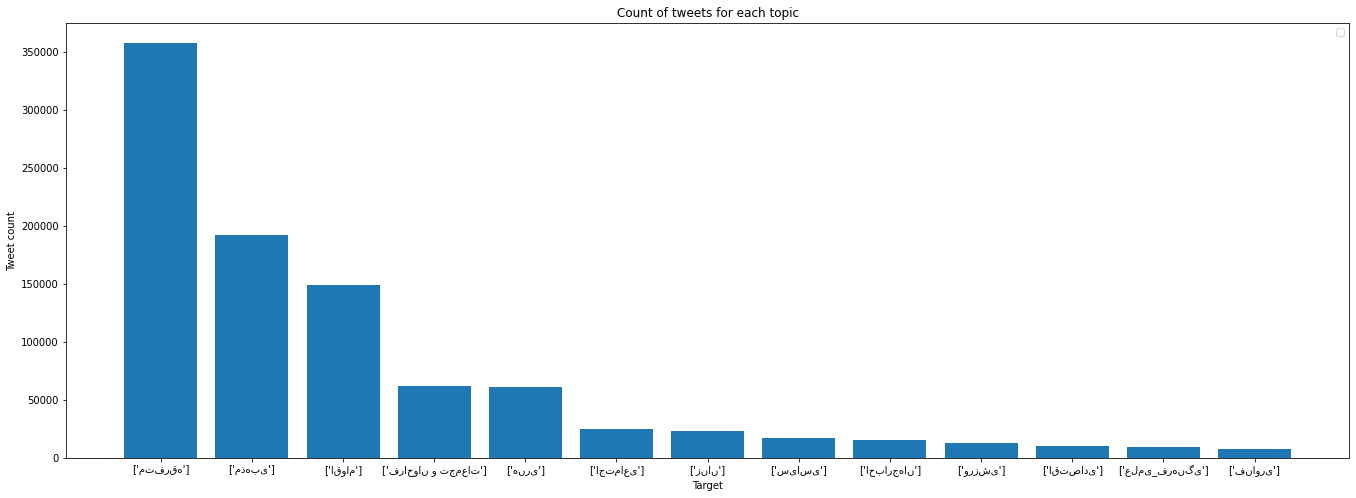

In [12]:
class_count = data['target'].value_counts()
plt.figure(figsize = (23, 8))
plt.bar(x = class_count.keys(), 
        height = class_count.values)
plt.xlabel("Target")
plt.ylabel("Tweet count")
plt.title("Count of tweets for each topic")
plt.legend()

## Farsi

In [13]:
is_fa =  data['lang'] == 'fa'
fa_data = data[is_fa]
fa_data.head()

,lang,text,target
1,fa,آن شب اسفندماه که برای نخستین بار خبر درگذشت #...,['اجتماعی']
3,fa,جدا از رفتن شجریان، چهر‌ه‌های غمبار همایون و ع...,['هنری']
4,fa,دیگه تویی که تا دیروز عکس سردار دلها رو استوری...,['هنری']
5,fa,لازم نیست راجع‌به هر مسئله‌ای نظر بدی و موضع‌گ...,['مذهبی']
6,fa,به نظر من اینکه رفیق صمیمیت لانگ دیستنس باشه ب...,['مذهبی']


In [14]:
fa_data.shape

(337104, 3)

No handles with labels found to put in legend.


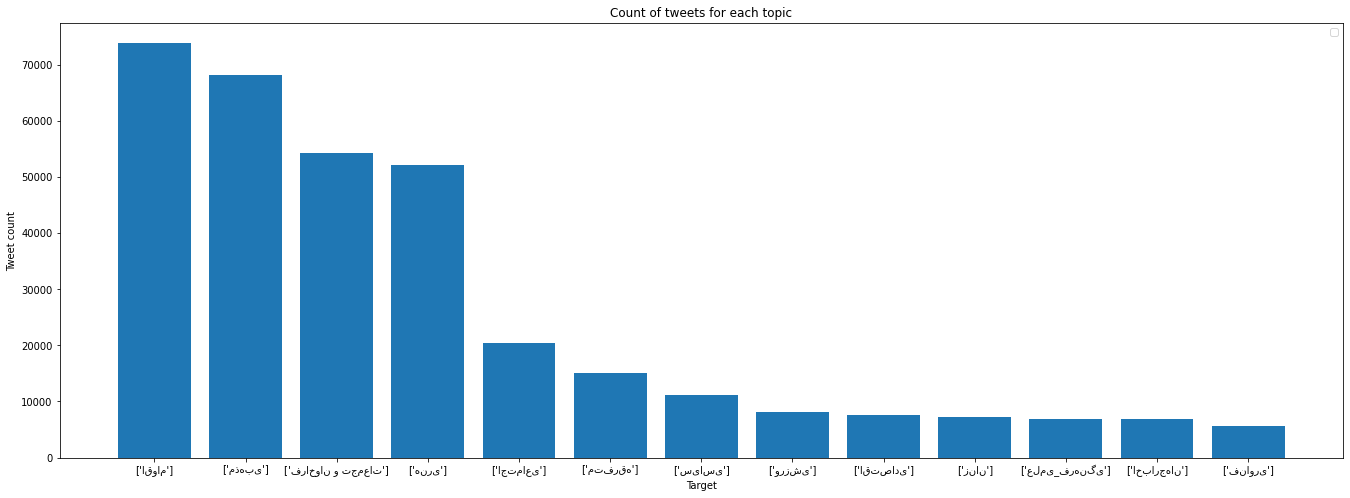

In [15]:
class_count = fa_data['target'].value_counts()
plt.figure(figsize = (23, 8))
plt.bar(x = class_count.keys(), 
        height = class_count.values)
plt.xlabel("Target")
plt.ylabel("Tweet count")
plt.title("Count of tweets for each topic")
plt.legend()

we need to normalize volum of data in each category!

## English

In [16]:
is_en =  data['lang'] == 'en'
en_data= data[is_en]
en_data.head()

,lang,text,target
2,en,@daydreaminblack Niiiice😂😂😂😂😂,['متفرقه']
23,en,@safewordthe۲nd ….,['متفرقه']
39,en,"@wahid_taniwal It seems, Taliban endorsed Pres...",['متفرقه']
40,en,"Mujahid told CBS News in a phone interview, «W...",['متفرقه']
41,en,"With fragile peace talks, the #COVID-۱۹ pandem...",['متفرقه']


In [17]:
en_data.shape

(286065, 3)

No handles with labels found to put in legend.


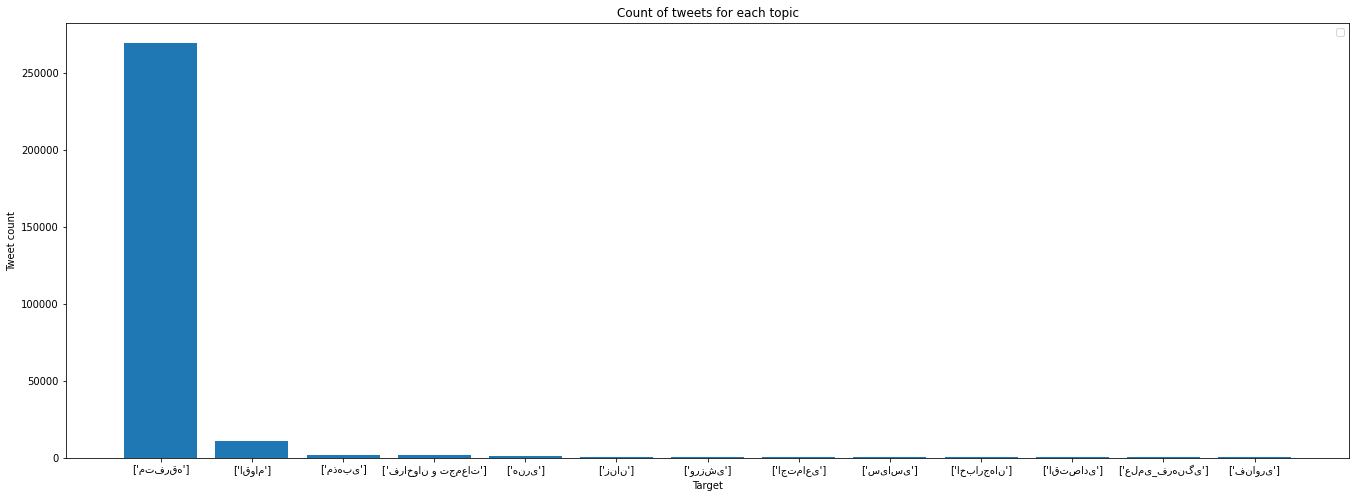

In [18]:
class_count = en_data['target'].value_counts()
plt.figure(figsize = (23, 8))
plt.bar(x = class_count.keys(), 
        height = class_count.values)
plt.xlabel("Target")
plt.ylabel("Tweet count")
plt.title("Count of tweets for each topic")
plt.legend()

we don't have a good data for english! so no model training.

#Preprocess

In [19]:
def tokenizer(text):
  text = text.str.split(' ')
  return text

In [20]:
def stemLemmaStopWord(stemmer, lemmatizer, stopwords, alphabet, tokens):
  final_tokens = []
  for token in tokens:
    stemmed_token = stemmer.stem(lemmatizer.lemmatize(token))
    if '#' in stemmed_token:
      stemmed_token = stemmed_token.split('#')[0]
    if token not in stopwords and stemmed_token not in stopwords and not token == '' and stemmed_token not in alphabet:
      final_tokens.append(stemmed_token)
  return final_tokens

In [21]:
def num_words(words):
  return len(words)

def num_distinct_words(words):
  return len(set(words))

def all_words(data):
  words = set()
  for text in data.text:
    for word in text:
      words.add(word)
  return words

In [22]:
fa_data.head()

,lang,text,target
1,fa,آن شب اسفندماه که برای نخستین بار خبر درگذشت #...,['اجتماعی']
3,fa,جدا از رفتن شجریان، چهر‌ه‌های غمبار همایون و ع...,['هنری']
4,fa,دیگه تویی که تا دیروز عکس سردار دلها رو استوری...,['هنری']
5,fa,لازم نیست راجع‌به هر مسئله‌ای نظر بدی و موضع‌گ...,['مذهبی']
6,fa,به نظر من اینکه رفیق صمیمیت لانگ دیستنس باشه ب...,['مذهبی']


In [23]:
def fa_normalize(text):
  text = text.replace(to_replace =r"[ئيی]", value = 'ی', regex = True)
  text = text.replace(to_replace =r"[ك]", value = 'ک', regex = True)
  text = text.replace(to_replace =r"[ؤ]", value = 'و', regex = True)
  text = text.replace(to_replace =r"[ة]", value = 'ه', regex = True)
  text = text.replace(to_replace=r"[إأآا]", value="ا", regex=True)
  text = text.replace(
            to_replace=r"[^ابپتثجچحخدذرزژسشصضطظعغفقکگلمنوهی]", value=" ", regex=True
        )
  text = text.replace(to_replace=r'(.)\1+', value=r'\1', regex=True)
  text = text.replace(to_replace =r"[^\S\n\t]+", value = ' ', regex = True)
  return text  


fa_data.text = fa_normalize(fa_data.text)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


tokenize

In [24]:
fa_data.text = tokenizer(fa_data.text)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Stem Lemma StopWord

In [25]:
fa_stemmer = hazm.Stemmer()
fa_lemmatizer = hazm.Lemmatizer()
fa_stopwords = hazm.stopwords_list()
fa_alphabet = set(list('ابپتثجچحخدذرزژسشصضطظعغفقکگلمنوهی'))

fa_data.text = fa_data.apply(lambda row: stemLemmaStopWord(fa_stemmer, fa_lemmatizer, fa_stopwords, fa_alphabet, row.text), axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


number of words

In [26]:
fa_data['words_num'] = fa_data.apply(lambda row: num_words(row.text), axis=1)
fa_data['distinct_words_num'] = fa_data.apply(lambda row: num_distinct_words(row.text), axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Remove less than 6 words long data

In [27]:
fa_data = fa_data[fa_data.words_num > 5]
fa_data .reset_index(drop=True, inplace=True)
fa_data.head()

,lang,text,target,words_num,distinct_words_num
0,fa,"[, شب, اسفندماه, خبر, درگذ, محمدرضاشجر, امد, م...",['اجتماعی'],28,24
1,fa,"[جدا, رفتن, شجر, چهر, , غمبار, همایون, علیزاده...",['هنری'],11,11
2,fa,"[دیگه, دیروز, عکس, سردار, دل, استور, میکرد, نم...",['هنری'],12,12
3,fa,"[رفیق, صمیم, لانگ, دیستنس, باشه, مراتب, سخ, , ...",['مذهبی'],12,10
4,fa,"[اون, سپرد, باد, حسر, ندار, زویازاکار]",['هنری'],6,6


In [28]:
words = all_words(fa_data)
print('all farsi words: ', sum(fa_data.words_num), ' and distinct farsi words: ', len(words))

all farsi words:  3264335  and distinct farsi words:  83624


# Balance data

In [29]:
balanced_data = fa_data.reindex(fa_data.words_num.sort_values().index)

In [30]:
def normalize_size(data):
  class_count = data['target'].value_counts()
  variance = statistics.variance(class_count)
  cutoff = variance//9
  while variance > cutoff :
    class_count = data['target'].value_counts()
    mean_size = class_count.mean()

    mean_size = int(mean_size)
    variance = statistics.variance(class_count)

    new_data = pd.DataFrame([], columns=data.columns)

    for x in tages:
      data_x = data[data.target == x]
      data_x.reset_index(drop=True, inplace=True)
      if data_x.shape[0] > mean_size:
        data_x = data_x[-mean_size:]
      frames = [new_data, data_x]
      new_data = pd.concat(frames)

    data = new_data

  data.reset_index(drop=True, inplace=True)
  return data

In [31]:
balanced_data = normalize_size(balanced_data)
# shuffle
balanced_data  = balanced_data.sample(frac = 1)
balanced_data.reset_index(drop=True, inplace=True)

No handles with labels found to put in legend.


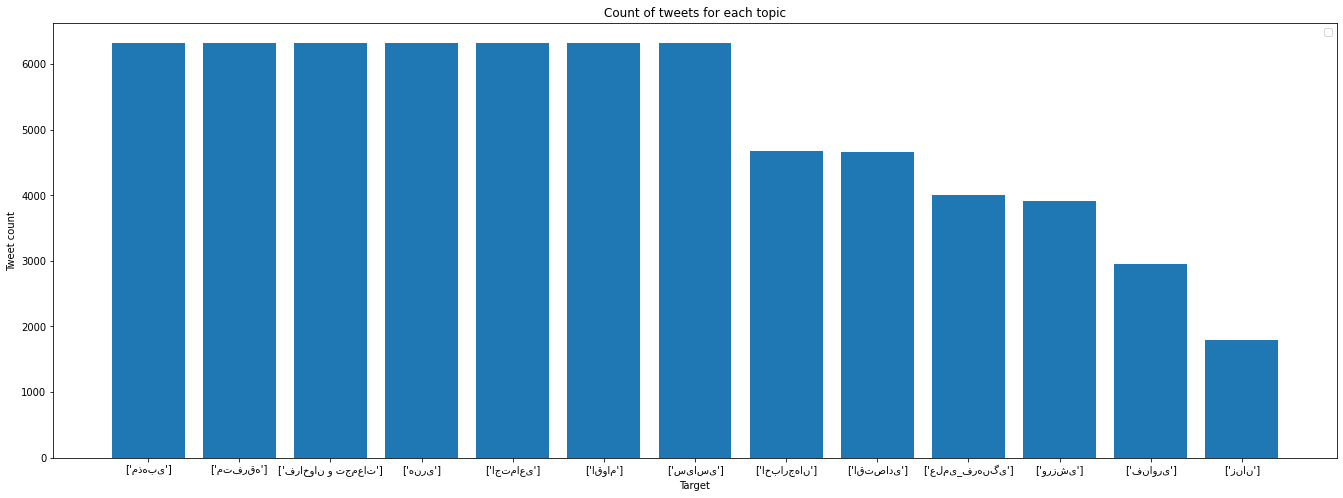

In [32]:
class_count = balanced_data['target'].value_counts()
plt.figure(figsize = (23, 8))
plt.bar(x = class_count.keys(), 
        height = class_count.values)
plt.xlabel("Target")
plt.ylabel("Tweet count")
plt.title("Count of tweets for each topic")
plt.legend()

#Prepare test and train sets

In [33]:
total_len = fa_data.shape[0]

train_len = 60*total_len//100
train_fa_data = fa_data.iloc[:train_len, :]
test_fa_data = fa_data.iloc[train_len:, :]

In [34]:
total_len = balanced_data.shape[0]

train_len = 60*total_len//100
train_balanced_data = balanced_data.iloc[:train_len, :]
test_balanced_data = balanced_data.iloc[train_len:, :]

In [35]:
# dev data
total_len = test_fa_data.shape[0]
dev_len = 50*total_len//100
dev_fa_data = test_fa_data.iloc[:dev_len, :]
test_fa_data = test_fa_data.iloc[dev_len:, :]

total_len = test_balanced_data.shape[0]
dev_len = 50*total_len//100
dev_balanced_data = test_balanced_data.iloc[:dev_len, :]
test_balanced_data = test_balanced_data.iloc[dev_len:, :]

#TF-IDF Vectorizer

In [36]:
X_fa_train = train_fa_data.text.apply(lambda x: np.str_(x))
y_fa_train = train_fa_data.target

X_fa_test = test_fa_data.text.apply(lambda x: np.str_(x))
y_fa_test = test_fa_data.target

X_fa_dev = dev_fa_data.text.apply(lambda x: np.str_(x))
y_fa_dev = dev_fa_data.target

In [37]:
X_b_train = train_balanced_data.text.apply(lambda x: np.str_(x))
y_b_train = train_balanced_data.target

X_b_test = test_balanced_data.text.apply(lambda x: np.str_(x))
y_b_test = test_balanced_data.target

X_b_dev = dev_balanced_data.text.apply(lambda x: np.str_(x))
y_b_dev = dev_balanced_data.target

In [38]:
tfidfVectorizer = TfidfVectorizer(min_df = 5, max_features = 1000)
tfidfVectorizer.fit(X_fa_train)
X_train_fa_vector = tfidfVectorizer.transform(X_fa_train)
X_test_fa_vector = tfidfVectorizer.transform(X_fa_test)
X_dev_fa_vector = tfidfVectorizer.transform(X_fa_dev)

In [39]:
tfidfVectorizer.fit(X_b_train)
X_train_b_vector = tfidfVectorizer.transform(X_b_train)
X_test_b_vector = tfidfVectorizer.transform(X_b_test)
X_dev_b_vector = tfidfVectorizer.transform(X_b_dev)

In [40]:
# save
filename = 'tfidf_fa.sav'
pickle.dump(tfidfVectorizer, open(filename, 'wb'))

#NB

original data

In [41]:
nb_model = MultinomialNB()
nb_model.fit(X_train_fa_vector, y_fa_train)
prediction_fa = nb_model.predict(X_test_fa_vector)
print(classification_report(y_fa_test, prediction_fa))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                      precision    recall  f1-score   support

         ['اجتماعی']       0.53      0.23      0.32      2598
       ['اخبارجهان']       0.50      0.42      0.45       902
         ['اقتصادی']       0.80      0.49      0.61       895
           ['اقوام']       0.42      0.42      0.42      8216
            ['زنان']       0.00      0.00      0.00       360
           ['سیاسی']       0.58      0.34      0.43      1546
     ['علمی_فرهنگی']       0.79      0.12      0.21       811
['فراخوان و تجمعات']       0.54      0.45      0.49      7021
          ['فناوری']       0.84      0.04      0.08       605
          ['متفرقه']       0.68      0.20      0.31      1575
           ['مذهبی']       0.40      0.70      0.51      9246
            ['هنری']       0.58      0.57      0.58      7021
           ['ورزشی']       0.54      0.23      0.33       748

            accuracy                           0.47     41544
           macro avg       0.55      0.32      0.36     41544
      

balanced data

In [42]:
nb_model.fit(X_train_b_vector, y_b_train)
prediction_b = nb_model.predict(X_test_b_vector)
print(classification_report(y_b_test, prediction_b))

                      precision    recall  f1-score   support

         ['اجتماعی']       0.51      0.51      0.51      1267
       ['اخبارجهان']       0.59      0.64      0.61       890
         ['اقتصادی']       0.68      0.69      0.68       988
           ['اقوام']       0.47      0.41      0.44      1256
            ['زنان']       0.32      0.07      0.12       370
           ['سیاسی']       0.56      0.65      0.60      1263
     ['علمی_فرهنگی']       0.55      0.26      0.35       757
['فراخوان و تجمعات']       0.51      0.46      0.48      1293
          ['فناوری']       0.48      0.31      0.38       597
          ['متفرقه']       0.56      0.44      0.49      1266
           ['مذهبی']       0.36      0.57      0.44      1246
            ['هنری']       0.49      0.73      0.59      1185
           ['ورزشی']       0.62      0.55      0.58       856

            accuracy                           0.52     13234
           macro avg       0.52      0.48      0.48     13234
      

In [43]:
filename = 'nb_fa.sav'
pickle.dump(nb_model, open(filename, 'wb'))

#RF

##tune

In [44]:
parameters = {#'n_estimators': (10, 30, 50, 70, 90),
              #'criterion': ('gini', 'entropy'),
              'max_depth': (200, 250, 300),
              #'max_features': ('auto', 'sqrt'),
              #'min_samples_split': (2, 3),
              'min_samples_leaf': (15, 20),
              # 'bootstrap' : (True, False),
              #'min_weight_fraction_leaf': (0.0, 0.1, 0.2, 0.3, 0.4)    
}

In [45]:
# rf_grid = GridSearchCV(RandomForestClassifier(n_jobs = -1, oob_score = False), param_grid = parameters, cv = 3, verbose = True)

farsi

In [46]:
# rf_grid_model = rf_grid.fit(X_dev_fa_vector, y_fa_dev)
# rf_grid_model.best_estimator_

##train and evaluate

original data

In [47]:
randomForestClassifier = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=300, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
randomForestClassifier.fit(X_train_fa_vector, y_fa_train)
prediction_fa = randomForestClassifier.predict(X_test_fa_vector)
print(classification_report(y_fa_test, prediction_fa))

                      precision    recall  f1-score   support

         ['اجتماعی']       0.66      0.35      0.46      2598
       ['اخبارجهان']       0.76      0.47      0.58       902
         ['اقتصادی']       0.63      0.57      0.60       895
           ['اقوام']       0.54      0.47      0.50      8216
            ['زنان']       1.00      0.00      0.01       360
           ['سیاسی']       0.80      0.48      0.60      1546
     ['علمی_فرهنگی']       0.85      0.21      0.34       811
['فراخوان و تجمعات']       0.60      0.57      0.58      7021
          ['فناوری']       0.66      0.13      0.22       605
          ['متفرقه']       0.83      0.35      0.49      1575
           ['مذهبی']       0.43      0.73      0.54      9246
            ['هنری']       0.65      0.64      0.65      7021
           ['ورزشی']       0.71      0.38      0.49       748

            accuracy                           0.55     41544
           macro avg       0.70      0.41      0.47     41544
      

balanced data

In [48]:
randomForestClassifier = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=300, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
randomForestClassifier.fit(X_train_b_vector, y_b_train)
prediction_b = randomForestClassifier.predict(X_test_b_vector)
print(classification_report(y_b_test, prediction_b))

                      precision    recall  f1-score   support

         ['اجتماعی']       0.64      0.59      0.61      1267
       ['اخبارجهان']       0.69      0.70      0.70       890
         ['اقتصادی']       0.66      0.71      0.69       988
           ['اقوام']       0.74      0.56      0.64      1256
            ['زنان']       0.35      0.53      0.42       370
           ['سیاسی']       0.67      0.76      0.71      1263
     ['علمی_فرهنگی']       0.61      0.45      0.51       757
['فراخوان و تجمعات']       0.78      0.63      0.70      1293
          ['فناوری']       0.46      0.39      0.42       597
          ['متفرقه']       0.59      0.60      0.60      1266
           ['مذهبی']       0.51      0.67      0.58      1246
            ['هنری']       0.64      0.76      0.69      1185
           ['ورزشی']       0.73      0.63      0.68       856

            accuracy                           0.63     13234
           macro avg       0.62      0.61      0.61     13234
      

In [49]:
# save
filename = 'rf_fa.sav'
pickle.dump(randomForestClassifier, open(filename, 'wb'))